In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
#import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time


from auto_encoder_submission import *
from bbox import *
from model_loader import *
from test_nn_submission import *

In [2]:
model_loader = ModelLoader()

Loading musketeer.pt


In [3]:
#omg it loaded

In [4]:
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [5]:
#make a simple validation loader
labeled_scene_index = np.array([132, 133])
#copied from run_test.py

labeled_trainset_task1 = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=labeled_scene_index,
    transform=get_transform_task1(),
    extra_info=False
    )
dataloader_task1 = torch.utils.data.DataLoader(
    labeled_trainset_task1,
    batch_size=1,
    shuffle=False,
    num_workers=4
    )

In [6]:
#check bouding box
total = 0
total_ats_bounding_boxes = 0
total_ts_road_map = 0

with torch.no_grad():
    for i, data in enumerate(dataloader_task1):
        total += 1
        sample, target, road_image = data
        sample = sample.cuda()
        
        predicted_bounding_boxes = model_loader.get_bounding_boxes(sample)[0].cpu() #does this solve our problem of first element
        if i%10 ==0:
            print(predicted_bounding_boxes.shape, target['bounding_box'][0].shape)
            print(predicted_bounding_boxes.min(), predicted_bounding_boxes.max())



torch.Size([100, 2, 4]) torch.Size([20, 2, 4])
tensor(-3.4588) tensor(2.9859)
torch.Size([100, 2, 4]) torch.Size([19, 2, 4])
tensor(-3.7445) tensor(3.0575)
torch.Size([100, 2, 4]) torch.Size([30, 2, 4])
tensor(-0.5293) tensor(2.1804)
torch.Size([100, 2, 4]) torch.Size([32, 2, 4])
tensor(-3.7500) tensor(2.7015)
torch.Size([100, 2, 4]) torch.Size([34, 2, 4])
tensor(-3.7527) tensor(3.4859)
torch.Size([100, 2, 4]) torch.Size([38, 2, 4])
tensor(-3.5819) tensor(3.6586)
torch.Size([100, 2, 4]) torch.Size([37, 2, 4])
tensor(-3.4591) tensor(3.4547)
torch.Size([100, 2, 4]) torch.Size([33, 2, 4])
tensor(-3.7520) tensor(3.6515)
torch.Size([100, 2, 4]) torch.Size([34, 2, 4])
tensor(-3.5781) tensor(3.6503)
torch.Size([100, 2, 4]) torch.Size([36, 2, 4])
tensor(-0.7386) tensor(3.6509)
torch.Size([100, 2, 4]) torch.Size([35, 2, 4])
tensor(-3.4409) tensor(3.6491)
torch.Size([100, 2, 4]) torch.Size([24, 2, 4])
tensor(-3.5906) tensor(3.2425)
torch.Size([100, 2, 4]) torch.Size([20, 2, 4])
tensor(-3.4550) t

In [7]:
#check on output
predicted_bounding_boxes

tensor([[[ 3.4236,  3.4236,  2.9915,  2.9915],
         [-0.6878, -0.8930, -0.6878, -0.8930]],

        [[-2.4128, -2.4128, -2.8653, -2.8653],
         [ 0.6976,  0.4924,  0.6976,  0.4924]],

        [[ 3.2719,  3.2719,  2.8232,  2.8232],
         [ 2.3748,  2.1718,  2.3748,  2.1718]],

        [[-0.1121, -0.1121, -0.5483, -0.5483],
         [ 3.3146,  3.1099,  3.3146,  3.1099]],

        [[ 3.2720,  3.2720,  2.8229,  2.8229],
         [ 2.2948,  2.0923,  2.2948,  2.0923]],

        [[ 3.2696,  3.2696,  2.8198,  2.8198],
         [ 2.4544,  2.2509,  2.4544,  2.2509]],

        [[ 0.0521,  0.0521, -0.3789, -0.3789],
         [ 2.9867,  2.7841,  2.9867,  2.7841]],

        [[ 3.1875,  3.1875,  2.7386,  2.7386],
         [ 2.3345,  2.1298,  2.3345,  2.1298]],

        [[ 0.0519,  0.0519, -0.3846, -0.3846],
         [ 3.3129,  3.1075,  3.3129,  3.1075]],

        [[ 3.3513,  3.3513,  2.9000,  2.9000],
         [ 2.3340,  2.1337,  2.3340,  2.1337]],

        [[ 3.3530,  3.3530,  2.9012,  2.

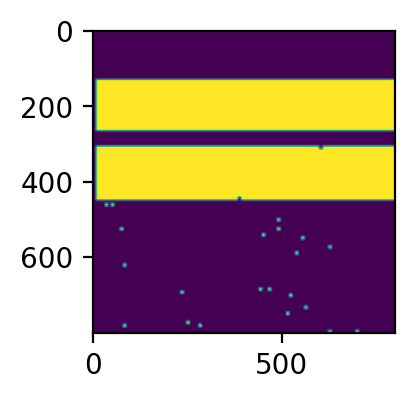

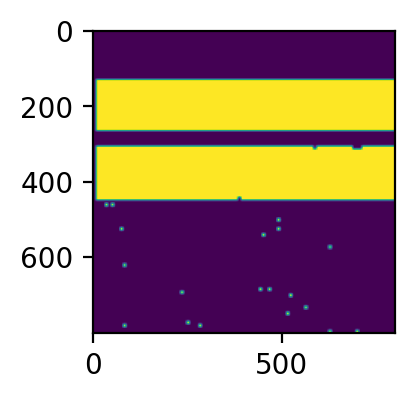

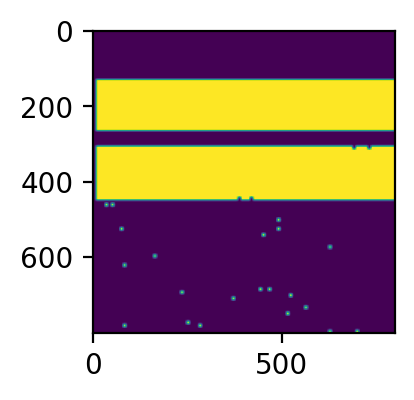

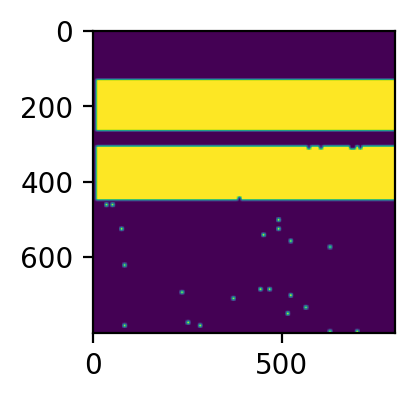

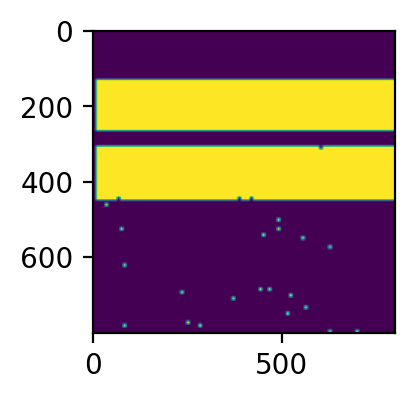

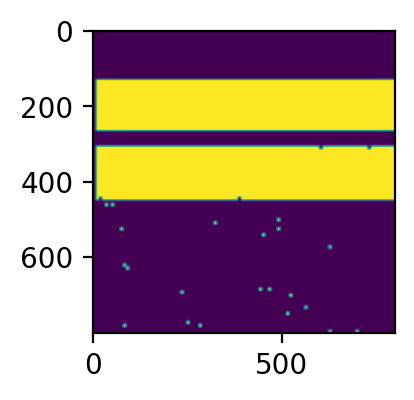

In [8]:
with torch.no_grad():
    for i, data in enumerate(dataloader_task1):
        
        sample, target, road_image = data
        sample = sample.cuda()
        
        predicted_road_map = model_loader.get_binary_road_map(sample).cpu()
        plt.figure(figsize=(2,2))
        plt.imshow(predicted_road_map[0].cpu().data.numpy())
        if i ==5:
            break

In [9]:
predicted_road_map.shape

torch.Size([1, 800, 800])

In [10]:
predicted_road_map.min()

tensor(0., dtype=torch.float64)

In [11]:
predicted_road_map.max()

tensor(1., dtype=torch.float64)